In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib as mpl
from transformers import pipeline

%matplotlib inline
sns.set_style('white')
plt.rcParams['font.size'] = 20
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True


In [5]:
# These candidates labels come from https://www.pnas.org/doi/10.1073/pnas.1702247114
candidate_labels = ['adoration', 'admiration', 'aesthetic experience','amusement', 'anger', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'confusion',
                    'craving', 'disgust', 'empathy', 'entrancement', 'excitement', 'fear', 'horror', 'interest', 'joy', 'nostalgia', 'relief',
                    'romance', 'sadness', 'satisfaction', 'sexual desire', 'surprise']

# We read all of our reports.
files = glob.glob(r'C:\Users\tlaieboriaa\Desktop\BreathWork\EnglishTranscripts\*English.txt', recursive=True)

# Initializing where the emotion probabilities will be stored.
scores = []

# In order to assign a probability to each of the candidate labels, we will deploy a pretrained LLM.
# Particularly, making use of HugginFace's pipeline, without training (zero-shot classification), we
# can directly make use of Meta's BART (https://arxiv.org/abs/1910.13461), trained on the 
# MultiNLI (MNLI) dataset (https://huggingface.co/datasets/multi_nli).

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Loop over participants.
for text in files:
    with open(text, "r") as fic:
        content = fic.read().replace('\n', '')

    # We'll classify each sentence according to the candidate emotions we pre-defined.
    sentences = list(map(str.strip, content.split(".")))
    scores2 = pd.DataFrame(data = np.zeros((len(sentences),len(candidate_labels))), columns = candidate_labels)
    for i in range(len(sentences)):
        if len(sentences[i]):
            claf = classifier(sentences[i], candidate_labels)
            for j in range(len(candidate_labels)):
                scores2[candidate_labels[j]].values[i] = claf['scores'][claf['labels'].index(candidate_labels[j])]
    scores2.iloc[scores2.values == 0] = np.nan
    scores.append(scores2)

np.savez('Scores_PerParticipant_English_30032023.npz',*scores)

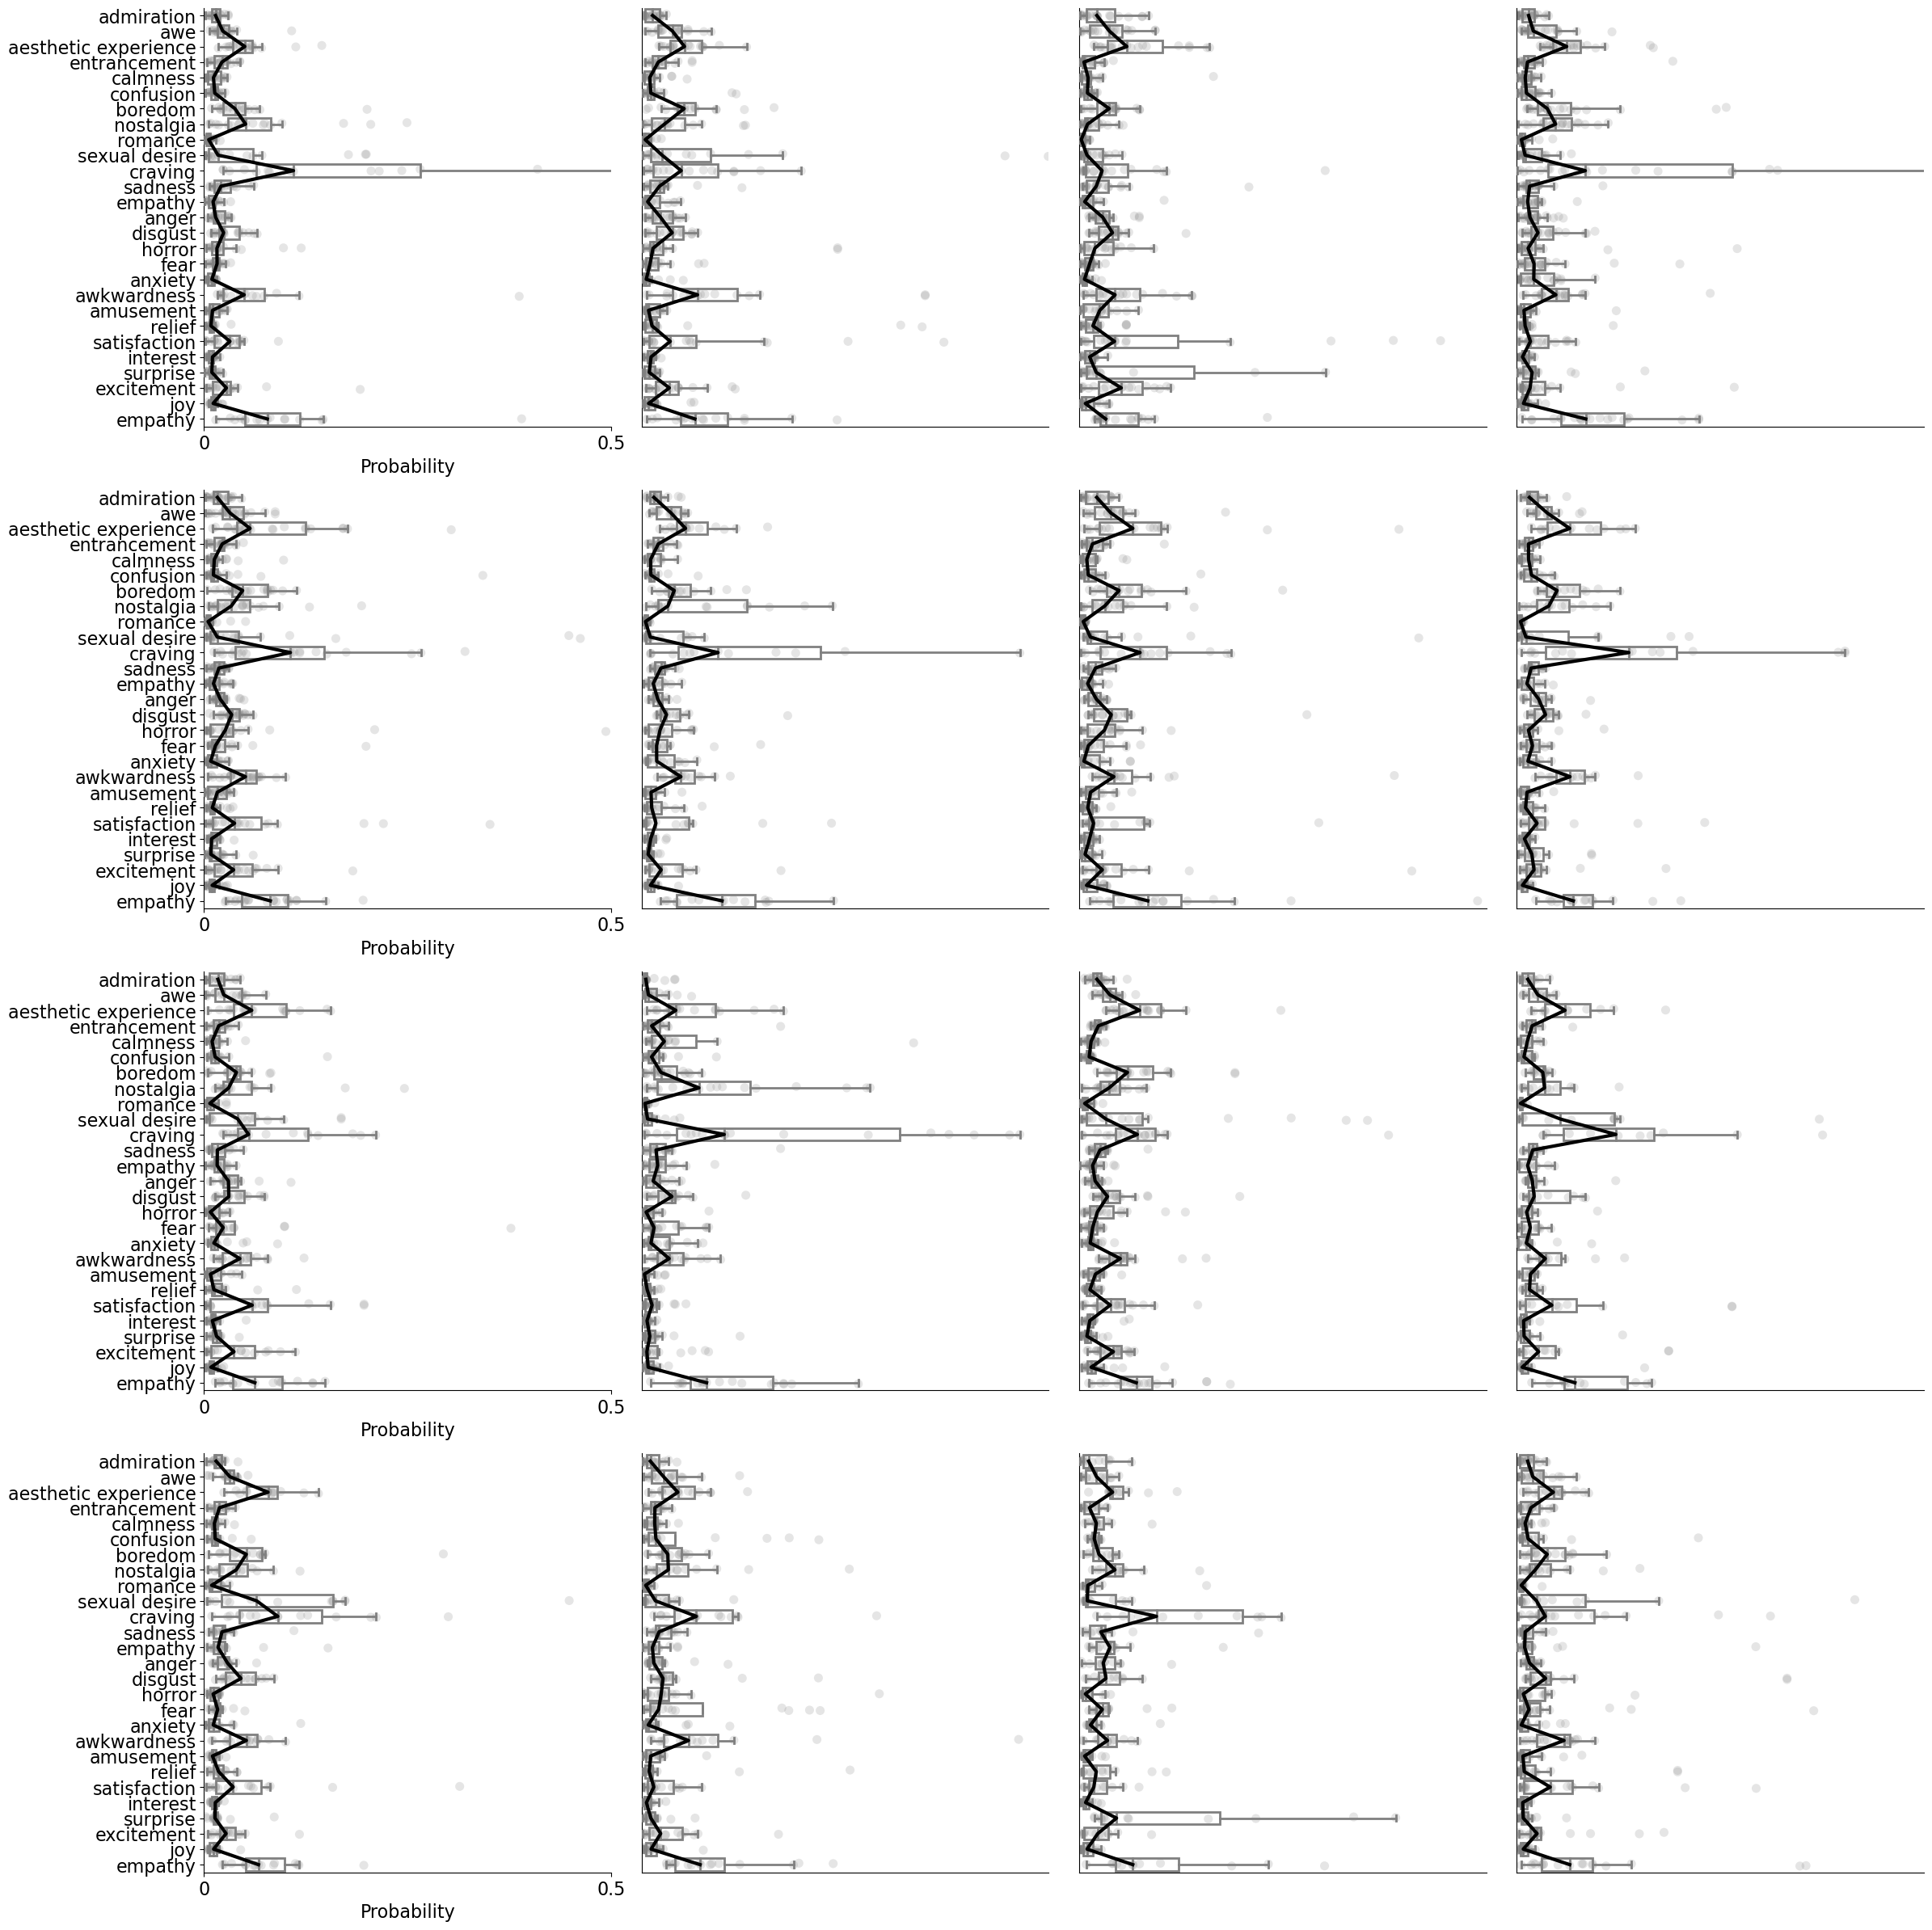

In [3]:
import numpy as np
import matplotlib.pyplot as plt

scores = np.load('Scores_PerParticipant_English_30032023.npz', allow_pickle=True)
candidate_labels2 = ['admiration', 'awe', 'aesthetic experience', 'entrancement', 'calmness', 'confusion', 'boredom', 'nostalgia',
                    'romance', 'sexual desire', 'craving', 'sadness', 'pain', 'anger', 'disgust', 'horror', 'fear', 'anxiety', 
                    'awkwardness', 'amusement', 'relief', 'satisfaction', 'interest', 'surprise', 'excitement', 'joy', 'empathy']
newOrder = []
for ii, elem in enumerate(candidate_labels2):
    newOrder.append([i for i, e in enumerate(candidate_labels) if e == 'empathy'][0])

newOrder = np.array(newOrder)
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (24,24))
counter = 0
for ii in scores.keys():
    axi = ax.flat[counter]
    sns.stripplot(data = scores[ii][newOrder], orient = 'horizontal', color = 'gray', size = 8, alpha = 0.2, jitter = 0.1, ax = axi, zorder = 0)
    sns.boxplot(data = scores[ii][newOrder], orient = 'horizontal', color = 'gray', ax = axi, showfliers = False,
                boxprops=dict(color='gray', facecolor="gray", alpha=1, linewidth = 2),
                medianprops=dict(color='black', linewidth=2), whiskerprops=dict(color='black'),
                capprops=dict(color="black"), zorder=3)
    for i,artist in enumerate(axi.patches):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor('gray')
        artist.set_facecolor('None')
        # Each box has 5 associated Line2D objects (because there are no outliers)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axi.lines[j]
            line.set_color('gray')
            line.set_mfc('gray')
            line.set_mec('gray')
            line.set_lw(2)
    axi.set_xlim([0, 0.5])
    axi.set_xticks([0, 0.5])
    if counter in [0, 4, 8, 12]:
        axi.set_yticklabels(np.array(candidate_labels)[newOrder], fontsize = 16, rotation = 0)
        axi.set_xticklabels(['0', '0.5'], fontsize = 16)
        axi.set_xlabel('Probability', fontsize = 16)
    else:
        axi.set_xticks([])
        axi.set_yticks([])
    counter += 1
    axi.plot(np.nanmedian(scores[ii][newOrder], axis = 0), candidate_labels, ms = 8, alpha = 1, color = 'black', lw = 3, zorder = 4)

sns.despine()
plt.tight_layout()
# plt.savefig('EmotionProbabilities_perParticipant_perSentence_EnglishTranscripts_24042023.pdf', transparent = True)